<a href="https://colab.research.google.com/github/fraco03/6D_pose/blob/main/notebooks/pose_rgb/pose_rbg_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import sys

# Clone or pull part
repo_url = "https://github.com/fraco03/6D_pose.git"
repo_dir = "/content/6D_pose"   #Modify here for kaggle
branch = "main"

# Clone if missing
if not os.path.exists(repo_dir):
    !git clone -b {branch} {repo_url}
    print(f"Cloned {repo_url} to {repo_dir}")
else:
    %cd {repo_dir}
    !git fetch origin
    !git checkout {branch}
    !git reset --hard origin/{branch}
    %cd ..
    print(f"Updated {repo_url} to {repo_dir}")

# Add repository to Python path
if repo_dir not in sys.path:
    sys.path.insert(0, repo_dir)


Cloned https://github.com/fraco03/6D_pose.git to /content/6D_pose


Cloning into '6D_pose'...


In [ ]:
from google.colab import drive
from utils.load_data import mount_drive

# Mounting part
mount_drive()

dataset_root = "/content/drive/MyDrive/Linemod_preprocessed" #Modify here for kaggle

print("\n✅ Setup complete!")
print(f"📁 Dataset path: {dataset_root}")


Mounted at /content/drive
✅ Drive mounted at /content/drive

✅ Setup complete!
📁 Dataset path: /content/drive/MyDrive/Linemod_preprocessed


In [9]:
%pwd

'f:\\Magistrale\\Advanced Machine Learning\\6D_pose\\notebooks\\pose_rgb'

In [14]:
from src.pose_rgb.dataset import LineModPoseDataset
from src.pose_rgb.model import ResNetRotation, TranslationNet
from src.pose_rgb.pose_utils import quaternion_to_rotation_matrix, convert_rotation_to_quaternion, inverse_pinhole_projection
from src.pose_rgb.test_dataset import *
from src.pose_rgb.loss import AutomaticWeightedLoss
from torch.utils.data import Dataset, DataLoader
import pathlib
import torch.optim as optim
from tqdm import tqdm


In [ ]:
# root_dir = '/content/drive/MyDrive/Linemod_preprocessed' #Modify here for kaggle
# root_dir = "../../Linemod_preprocessed_smaller"  #Modify here for local

train_dataset = LineModPoseDataset(split='train', root_dir=root_dir)
test_dataset = LineModPoseDataset(split='test', root_dir=root_dir)

#Dataloder
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

 Loaded LineModPoseDataset
   Split: train
   Dir : [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
   Total samples: 1
 Loaded LineModPoseDataset
   Split: test
   Dir : [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
   Total samples: 41


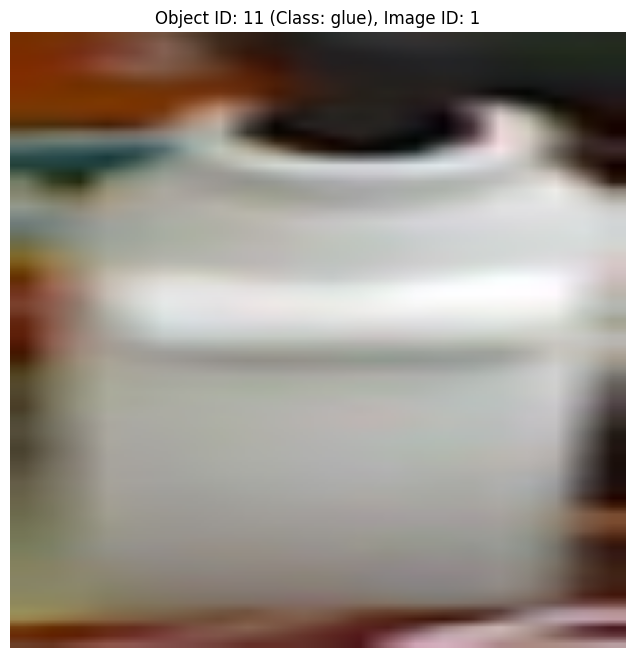


--- Posa 6D per Campione Casuale (ID Oggetto: 11) ---
  Rotazione (Quaternione w,x,y,z): [ 0.33200955  0.9432371   0.00782907 -0.00347811]
  Traslazione (mm) (tx,ty,tz): [ 0.0166968  -0.08082515  0.97878885]
  Classe Oggetto: glue


In [16]:
import matplotlib.pyplot as plt
import random
import torch
import numpy as np

def display_random_sample_with_pose(dataset):
    """
    Prende un campione casuale dal dataset, visualizza l'immagine
    e stampa le informazioni sulla posa 6D (rotazione e traslazione).

    Args:
        dataset: L'istanza del LineModPoseDataset da cui estrarre il campione.
    """
    # Scegli un indice casuale
    idx = random.randint(0, len(dataset) - 1)
    sample = dataset[idx]

    # Estrai i dati dal campione
    img_tensor = sample['image']
    rotation_quat = sample['rotation'].numpy() # Quaternion (w, x, y, z)
    translation_vec = sample['translation'].numpy() # Translation (tx, ty, tz)
    object_id = sample['object_id']
    class_idx = sample['class_idx']
    img_id = sample['img_id']

    # Denormalizza l'immagine per la visualizzazione
    # I valori di mean e std sono quelli usati per la normalizzazione di ImageNet
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    denormalized_img = img_tensor * std + mean

    # Converti in numpy e riorganizza le dimensioni da (C, H, W) a (H, W, C) per matplotlib
    img_np = denormalized_img.permute(1, 2, 0).numpy()

    # Assicurati che i valori siano nel range [0, 1] per la visualizzazione
    img_np = np.clip(img_np, 0, 1)

    # Visualizza l'immagine
    plt.figure(figsize=(8, 8))
    plt.imshow(img_np)
    plt.title(f"Object ID: {object_id} (Class: {class_idx}), Image ID: {img_id}")
    plt.axis('off')
    plt.show()

    # Stampa le informazioni sulla posa
    print(f"\n--- Posa 6D per Campione Casuale (ID Oggetto: {object_id}) ---")
    print(f"  Rotazione (Quaternione w,x,y,z): {rotation_quat}")
    print(f"  Traslazione (mm) (tx,ty,tz): {translation_vec}")
    print(f"  Classe Oggetto: {class_idx}")

# Esempio di utilizzo della funzione con il train_dataset
display_random_sample_with_pose(train_dataset)

In [18]:
import os
import torch
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
from datetime import datetime
from itertools import islice

# ==========================================
# 1. SETUP & HYPERPARAMETERS
# ==========================================
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50

# Creiamo una cartella specifica per questo run usando il timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
CHECKPOINT_DIR = f'/content/drive/MyDrive/runs/{timestamp}' # modify here for kaggle
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Assegno run_dir per compatibilità col tuo codice di plot
run_dir = CHECKPOINT_DIR

# Initialize Models
model_rot = ResNetRotation(freeze_backbone=True).to(DEVICE)
model_trans = TranslationNet().to(DEVICE)

# Initialize Loss & Optimizer
criterion = AutomaticWeightedLoss().to(DEVICE)

optimizer = torch.optim.Adam(
    list(model_rot.parameters()) + list(model_trans.parameters()) + list(criterion.parameters()), 
    lr=LEARNING_RATE
)

train_losses = []
val_losses = []

best_val_loss = float('inf')
best_epoch = 0

print(f"\n🔥 STARTING TRAINING on {DEVICE}...")
print(f"📁 Saving outputs to: {run_dir}")

# ==========================================
# 2. TRAINING LOOP
# ==========================================
for epoch in range(NUM_EPOCHS):

    # --- A. TRAIN PHASE ---
    model_rot.train()
    model_trans.train()

    running_train_loss = 0.0

    # Progress Bar for Training
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")

    for batch in pbar:
        # Move data to GPU
        imgs = batch['image'].to(DEVICE)
        bbox_info = batch['bbox_info'].to(DEVICE)
        gt_rot = batch['rotation'].to(DEVICE)
        gt_trans_abs = batch['translation'].to(DEVICE)
        cam_K = batch['cam_K'].to(DEVICE)
        bbox_centers = batch['bbox_center'].to(DEVICE)

        # Forward Pass
        pred_rot = model_rot(imgs)
        pred_trans = model_trans(imgs, bbox_info)

        # Back-Projection
        pred_deltas = pred_trans[:, :2]
        pred_z = pred_trans[:, 2]
        pred_3d_real = inverse_pinhole_projection(
            crop_center=bbox_centers,
            deltas=pred_deltas,
            z=pred_z * 1000,    # Convert to mm
            cam_K=cam_K
        )

        # Loss & Backprop
        loss, l_r, l_t = criterion(pred_rot, gt_rot, pred_3d_real, gt_trans_abs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        pbar.set_postfix({'Loss': f"{loss.item():.4f}"})


    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- B. EVALUATION PHASE ---
    model_rot.eval()
    model_trans.eval()

    running_val_loss = 0.0
    val_batches_limit = 50  # <--- too sample in the validation, take a subpart
    count_batches = 0

    with torch.no_grad():

        val_iterator = islice(test_loader, val_batches_limit)

        val_pbar =tqdm(val_iterator, total=val_batches_limit, desc="Validating")

        for batch in val_pbar:
            imgs = batch['image'].to(DEVICE)
            bbox_info = batch['bbox_info'].to(DEVICE)
            gt_rot = batch['rotation'].to(DEVICE)
            gt_trans_abs = batch['translation'].to(DEVICE)
            cam_K = batch['cam_K'].to(DEVICE)
            bbox_centers = batch['bbox_center'].to(DEVICE)

            # Forward
            pred_rot = model_rot(imgs)
            pred_trans = model_trans(imgs, bbox_info)

            # Inverse pinhole projection
            pred_deltas = pred_trans[:, :2]
            pred_z = pred_trans[:, 2]
            pred_3d_real = inverse_pinhole_projection(
                crop_center=bbox_centers,
                deltas=pred_deltas,
                z=pred_z * 1000,
                cam_K=cam_K
            )

            # Loss
            loss, _, _ = criterion(pred_rot, gt_rot, pred_3d_real, gt_trans_abs)
            running_val_loss += loss.item()

            count_batches += 1


    avg_val_loss = running_val_loss / count_batches
    val_losses.append(avg_val_loss)

    # --- C. REPORT & SAVE ---
    print(f"📊 Epoch {epoch+1} Summary: Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Save Best Model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch + 1

        save_path = os.path.join(CHECKPOINT_DIR, "best_model.pth")
        torch.save({
            'epoch': epoch,
            'model_rot': model_rot.state_dict(),
            'model_trans': model_trans.state_dict(),
            'val_loss': best_val_loss
        }, save_path)
        print(f"🏆 New Best Model Saved! (Loss: {best_val_loss:.4f})")

    # Save Last Checkpoint
    if (epoch + 1) == NUM_EPOCHS:
        torch.save({
            'epoch': epoch+1,
            'model_rot': model_rot.state_dict(),
            'model_trans': model_trans.state_dict(),
        }, os.path.join(CHECKPOINT_DIR, f"checkpoint_ep{epoch+1}.pth"))

print("\n🎉 TRAINING COMPLETE! Generating plots...")

🔒 ResNet backbone frozen.

🔥 STARTING TRAINING on cpu...
📁 Saving outputs to: /content/drive/MyDrive/runs/20251216_121639


Epoch 1/50 [Train]:   0%|          | 0/1 [00:18<?, ?it/s]


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 64])

In [ ]:
# Plot training history
plt.figure(figsize=(12, 6))

# Grafico Lineare
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o', alpha=0.7)
plt.plot(val_losses, label='Validation Loss', marker='s', alpha=0.7)
# best_epoch-1 perchè i plot partono da indice 0, ma l'epoca è 1-based
if best_epoch > 0:
    plt.axvline(x=best_epoch-1, color='r', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Grafico Logaritmico (Utile se la loss scende molto)
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', marker='o', alpha=0.7)
plt.plot(val_losses, label='Validation Loss', marker='s', alpha=0.7)
if best_epoch > 0:
    plt.axvline(x=best_epoch-1, color='r', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.yscale('log')
plt.title('Training and Validation Loss (Log Scale)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plot_path = os.path.join(run_dir, 'training_history.png')
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Training Statistics:")
print(f"   Total epochs: {len(train_losses)}")
print(f"   Best epoch: {best_epoch}")
print(f"   Best val loss: {best_val_loss:.6f}")
print(f"   Final train loss: {train_losses[-1]:.6f}")
print(f"   Final val loss: {val_losses[-1]:.6f}")

# Save training history to JSON
history = {
    'train_losses': [float(x) for x in train_losses],
    'val_losses': [float(x) for x in val_losses],
    'best_epoch': int(best_epoch),
    'best_val_loss': float(best_val_loss),
    'total_epochs': len(train_losses),
    'timestamp': timestamp
}

history_path = os.path.join(run_dir, 'training_history.json')
with open(history_path, 'w') as f:
    json.dump(history, f, indent=2)

print(f"\n💾 Training history saved to: {history_path}")
print(f"📈 Plot saved to: {plot_path}")